### The relationship between the ball travel distance and ball speed in which the ball is hit and the base that the batter reaches in the current round

In [130]:
# imports libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [131]:
# The ball and player data is generated by our own database with condition of event_code = 4 to analyze when the ball hits into play.
df_ball = pd.read_csv("Data/ball_pos_event.csv")
df_player = pd.read_csv('player&ball_pos_analysis/player_pos_analysis.csv')

##### Exploratory Data Analysis

In [132]:
df_ball

,playID,playPerGame,gameID,ballPositionX,ballPositionY,ballPositionZ,ballTimeStamp,eventCode
0,23916,3,1,-0.335508,54.21180,5.794710,38518,1.0
1,23916,3,1,-0.227452,47.68860,5.456370,38568,NaN
2,23916,3,1,-0.135159,41.22240,5.077170,38618,NaN
3,23916,3,1,-0.058631,34.81290,4.657110,38668,NaN
4,23916,3,1,0.002134,28.46016,4.196160,38718,NaN
...,...,...,...,...,...,...,...,...
542335,23751,249,97,-15.681480,262.10910,0.071624,8748322,NaN
542336,23751,249,97,-15.805920,263.79000,-0.053669,8748372,NaN
542337,23751,249,97,-15.944550,265.44180,-0.204321,8748422,NaN
542338,23751,249,97,-16.097310,267.06420,-0.380331,8748472,NaN


In [133]:
df_ball.isna().sum()

playID                0
playPerGame           0
gameID                0
ballPositionX         0
ballPositionY         0
ballPositionZ         0
ballTimeStamp         0
eventCode        504384
dtype: int64

In [134]:
df_ball['playID'].nunique() 

9059

There are total of 9059 playIDs which represent each play event and we will calculate the ball movement based on each playID.

In [135]:
df_ball[['ballPositionX','ballPositionY','ballPositionZ','ballTimeStamp']].describe()

,ballPositionX,ballPositionY,ballPositionZ,ballTimeStamp
count,542340.000000,542340.000000,542340.000000,5.423400e+05
mean,0.162617,121.173974,24.793925,4.989287e+06
std,61.535676,90.285735,39.140803,3.273884e+06
min,-266.744700,-43.000800,-24.180840,6.756000e+03
25%,-23.011702,44.207100,2.502112,2.305842e+06
50%,-0.215904,102.343350,6.170760,4.616852e+06
75%,27.495638,187.084275,29.127225,7.354254e+06
max,279.426600,482.847000,363.585000,1.951433e+07


In [136]:
## The distribution of the event code within each playID with condition of eventCode = 4
df_ball['eventCode'].value_counts()

1.0     9056
4.0     8937
16.0    8243
2.0     7359
3.0     3226
5.0      497
9.0      282
10.0     248
11.0     108
Name: eventCode, dtype: int64

##### Calculation of Travel Distance, Ball Speed, and Initial Ball Acceleration

In [137]:
# Function to calculate Euclidean distance between two points
def travel_distance(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

# Dictionary to store results for each playID
results = {}

# The start of the ball pos would be when the eventCode = 4, 
# and the end of the ball pos would be when the eventCode = 2 or 11
for playID, play_data in df_ball.groupby('playID'):
    event_codes = play_data['eventCode'].values
    
    start_idx = np.where(event_codes == 4)[0][0] if 4 in event_codes else None
    end_idx = next((i for i, code in enumerate(event_codes) if code in [2, 11]), None)
    
    if start_idx is not None and end_idx is not None:
        positions = play_data[['ballPositionX', 'ballPositionY', 'ballPositionZ']].values
        timestamps = play_data['ballTimeStamp'].values / 1000  # Convert to seconds
        
        positions = positions[start_idx:end_idx+1]
        timestamps = timestamps[start_idx:end_idx+1]
        
        speeds = []
        accelerations = []  # New list to store acceleration values
        
        if len(positions) > 1:  # Ensure at least two positions for initial acceleration calculation
            distance = travel_distance(*positions[0], *positions[1])
            time_interval = timestamps[1] - timestamps[0]
            
            if time_interval > 0:  # Avoid division by zero
                speed = distance / time_interval
                speeds.append(speed)
                
                # Calculate initial acceleration as change in speed over time
                initial_acceleration = speed / time_interval
                accelerations.append(initial_acceleration)
        
        total_distance = sum(travel_distance(*pos1, *pos2) for pos1, pos2 in zip(positions[:-1], positions[1:]))
        
        results[playID] = {
            'TotalDistance': total_distance,
            'AverageBallSpeed': np.mean(speeds) if speeds else 0,  # Set to 0 if no speeds available
            'InitialBallAcceleration': accelerations[0] if accelerations else 0  # Set to 0 if no accelerations available
        }
    else:
        results[playID] = {
            'TotalDistance': 0,
            'AverageBallSpeed': 0,
            'InitialBallAcceleration': 0
        }

output_df = pd.DataFrame.from_dict(results, orient='index')

# Reset the index and rename the columns
output_df.reset_index(inplace=True)
output_df.rename(columns={'index': 'playID'}, inplace=True)

print(output_df)

      playID  TotalDistance  AverageBallSpeed  InitialBallAcceleration
0          6     146.409737         76.303938              1526.078767
1          8       0.000000          0.000000                 0.000000
2          9       0.000000          0.000000                 0.000000
3         10       0.000000          0.000000                 0.000000
4         11       0.000000          0.000000                 0.000000
...      ...            ...               ...                      ...
9054   26297     142.418452        142.361659              2847.233174
9055   26298       0.000000          0.000000                 0.000000
9056   26300       0.000000          0.000000                 0.000000
9057   26302     350.872622         36.235475              1098.044697
9058   26303     189.547407        138.146846              2762.936917

[9059 rows x 4 columns]


If the totalDistance, AverageBallSpeed, and InitialBallAcceleration equal 0, that means that batter did not hit a 'good' ball that we want to analyze. We only include circumstance when the ball is getting hit and then the ball got acquired or home run.

In [138]:
output_df = output_df[output_df['TotalDistance'] != 0]
output_df

,playID,TotalDistance,AverageBallSpeed,InitialBallAcceleration
0,6,146.409737,76.303938,1526.078767
5,17,310.540927,157.514202,3150.284047
6,19,314.988930,31.240105,946.669840
7,25,139.815216,51.855510,1037.110196
10,31,231.371083,112.954350,3422.859079
...,...,...,...,...
9052,26283,365.215376,86.499800,1729.995991
9053,26295,123.375990,158.779034,3175.580683
9054,26297,142.418452,142.361659,2847.233174
9057,26302,350.872622,36.235475,1098.044697


There are over half of the ball which will not be considered as a 'good' ball that we will not analyze those with relationship of batter hitting base.

#### Player Analysis

In [139]:
sorted_df = df_player.groupby('gameID').apply(lambda x: x.sort_values(by=['playPerGame', 'playerTimeStamp'])).reset_index(drop=True)

In [140]:
# Build a new dataframe with every row contain the playID playPergame and gameID, also including a new feature
# "result" which have value 1, 2, 3 means batter run to first, second, third base.

# Used to save value
new_data = []

# find all the game id
unique_games = sorted_df['gameID'].unique()

for game_id in unique_games:
    game_data = sorted_df[sorted_df['gameID'] == game_id]
    
    # Now check details about each single game
    for i in range(len(game_data)):
        row = game_data.iloc[i]
        
        if row['posCode'] == 10:
            player_num = row['playerNum']
            play_per_game = row['playPerGame']
            next_play_per_game = play_per_game + 1
            
            next_row = game_data[(game_data['playPerGame'] == next_play_per_game) & 
                                 (game_data['playerNum'] == player_num) & 
                                 (game_data['posCode'].isin([11, 12, 13]))]
            
            if not next_row.empty:
                result = next_row['posCode'].values[0] - 10
                new_data.append((row['playID'], play_per_game, game_id, result))

# build new dataframe
new_columns = ['playID', 'playPerGame', 'gameID', 'result']
batter_df = pd.DataFrame(new_data, columns=new_columns)

In [141]:
batter_df.head(10)

,playID,playPerGame,gameID,result
0,25953,6,1,1
1,7027,14,1,1
2,21697,23,1,2
3,6627,43,1,1
4,5766,45,1,1
5,5248,54,1,1
6,2710,55,1,2
7,6079,64,1,1
8,5869,72,1,1
9,8133,83,1,1


In [142]:
# append the result of batter run to first, second, third base.
ball_pos_batter_df = pd.merge(output_df,batter_df, on='playID', how='left')
ball_pos_batter_df

,playID,TotalDistance,AverageBallSpeed,InitialBallAcceleration,playPerGame,gameID,result
0,6,146.409737,76.303938,1526.078767,NaN,NaN,NaN
1,17,310.540927,157.514202,3150.284047,NaN,NaN,NaN
2,19,314.988930,31.240105,946.669840,169.0,93.0,1.0
3,25,139.815216,51.855510,1037.110196,NaN,NaN,NaN
4,31,231.371083,112.954350,3422.859079,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4483,26283,365.215376,86.499800,1729.995991,NaN,NaN,NaN
4484,26295,123.375990,158.779034,3175.580683,NaN,NaN,NaN
4485,26297,142.418452,142.361659,2847.233174,NaN,NaN,NaN
4486,26302,350.872622,36.235475,1098.044697,54.0,67.0,2.0


In [143]:
ball_pos_batter_df.sample(10)

,playID,TotalDistance,AverageBallSpeed,InitialBallAcceleration,playPerGame,gameID,result
3979,23316,124.754796,114.793158,2295.863151,NaN,NaN,NaN
3451,20336,232.560691,86.746989,1734.939780,NaN,NaN,NaN
752,4677,135.508723,68.699288,1373.985751,NaN,NaN,NaN
4049,23729,79.497526,36.390075,1102.729559,11.0,93.0,1.0
2588,15379,230.298431,49.093765,981.875308,NaN,NaN,NaN
2892,17035,334.893293,114.945538,2298.910755,NaN,NaN,NaN
4054,23753,387.480013,168.475850,3369.516993,NaN,NaN,NaN
424,2691,503.542156,110.140005,3337.575923,NaN,NaN,NaN
3433,20218,277.518011,79.865450,1597.308999,NaN,NaN,NaN
1599,9763,147.443424,28.897962,577.959245,NaN,NaN,NaN


In [144]:
# For better analysis, we fill all the NA values with 0 indicates that the batter hits the ball but does not hit the base.
ball_pos_batter_df = ball_pos_batter_df.fillna(0)

In [145]:
ball_pos_batter_df['result'].value_counts()

0.0    3691
1.0     620
2.0     160
3.0      17
Name: result, dtype: int64

In [146]:
# To find the relationship between batter hits the base and other factors, we replace result in which the 2 base and 3 base as 1 means the batter hits the base.
ball_pos_batter_df['result'] = ball_pos_batter_df['result'].replace([2, 3], 1)
df = ball_pos_batter_df
df

,playID,TotalDistance,AverageBallSpeed,InitialBallAcceleration,playPerGame,gameID,result
0,6,146.409737,76.303938,1526.078767,0.0,0.0,0.0
1,17,310.540927,157.514202,3150.284047,0.0,0.0,0.0
2,19,314.988930,31.240105,946.669840,169.0,93.0,1.0
3,25,139.815216,51.855510,1037.110196,0.0,0.0,0.0
4,31,231.371083,112.954350,3422.859079,0.0,0.0,0.0
...,...,...,...,...,...,...,...
4483,26283,365.215376,86.499800,1729.995991,0.0,0.0,0.0
4484,26295,123.375990,158.779034,3175.580683,0.0,0.0,0.0
4485,26297,142.418452,142.361659,2847.233174,0.0,0.0,0.0
4486,26302,350.872622,36.235475,1098.044697,54.0,67.0,1.0


In [ ]:
df.to_csv()

### Distribution of Result

In [147]:
#Count of the Posts for Each result
df['result'].value_counts()

0.0    3691
1.0     797
Name: result, dtype: int64

### Correlation Analysis

In [148]:
m = smf.logit("result ~ TotalDistance + AverageBallSpeed + InitialBallAcceleration", data = df).fit()
m.summary()

Optimization terminated successfully.
         Current function value: 0.465947
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 result   No. Observations:                 4488
Model:                          Logit   Df Residuals:                     4484
Method:                           MLE   Df Model:                            3
Date:                Fri, 01 Sep 2023   Pseudo R-squ.:                0.003772
Time:                        02:50:08   Log-Likelihood:                -2091.2
converged:                       True   LL-Null:                       -2099.1
Covariance Type:            nonrobust   LLR p-value:                  0.001226
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.9335      0.113    -17.154      0.000      -2.154      -1.713
TotalDistance               0.0010      0.000      3.132      0.002       0.000       0.002
AverageBallSpeed           -0.0002      0.002     -0.093      0.926      -0.004       0.004
InitialBallAcceleration  6.104e-05   8.75e-05      0.698      0.485      -0.000       0.000
===========================================================================================
"""

From the analysis above, we can see that there is positive relationship between total flying distance and the batter hits the base. As the ball travel distance increases, the batter is more likely to hit the base. The average ball speed is negatively correlated with the batter hitting on base. When the ball extremely fast, the time for batter to hit the base would be shorter. The ball acceleration has relatively low positive relationship with the batter performance.

In [150]:
m = smf.logit("result ~ AverageBallSpeed", data = df).fit()
m.summary()

Optimization terminated successfully.
         Current function value: 0.467070
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 result   No. Observations:                 4488
Model:                          Logit   Df Residuals:                     4486
Method:                           MLE   Df Model:                            1
Date:                Fri, 01 Sep 2023   Pseudo R-squ.:                0.001372
Time:                        02:51:13   Log-Likelihood:                -2096.2
converged:                       True   LL-Null:                       -2099.1
Covariance Type:            nonrobust   LLR p-value:                   0.01641
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.7275      0.091    -19.015      0.000      -1.906      -1.549
AverageBallSpeed     0.0014      0.001      2.408      0.016       0.000       0.003
====================================================================================
"""

From the analysis above, the only average ball speed would have relatively low positive relationship with the batter hitting the base. 

### Prediction Model

Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       733
         1.0       0.00      0.00      0.00       165

    accuracy                           0.82       898
   macro avg       0.41      0.50      0.45       898
weighted avg       0.67      0.82      0.73       898

Random Forest Results:
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       733
         1.0       0.26      0.10      0.15       165

    accuracy                           0.78       898
   macro avg       0.54      0.52      0.51       898
weighted avg       0.72      0.78      0.74       898



/Users/xuxiaobing/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xuxiaobing/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xuxiaobing/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


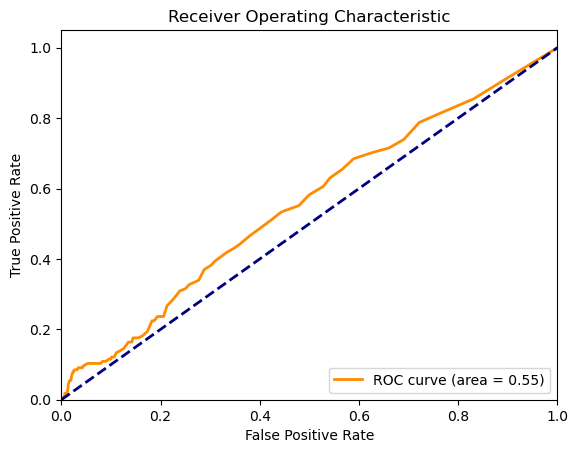

In [128]:
# Splitting the data into features (X) and target (y)
X = df[['TotalDistance', 'AverageBallSpeed', 'InitialBallAcceleration']]
y = df['result']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
logreg_preds = logreg_model.predict(X_test)

# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Model Evaluation
print("Logistic Regression Results:")
print(classification_report(y_test, logreg_preds))

print("Random Forest Results:")
print(classification_report(y_test, rf_preds))

# ROC Curve for Random Forest
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


1. The classification report provides a detailed breakdown of the performance of models, including precision, recall, and F1-score for each class. 
* In the logistic regression result, the precision is the ratio of true positive predictions to the total number of positive predictions(true positives+false positives). For the class 0, the precision is 82% accuracy to predict. 
* The recall is the ratio of true positive predictions to the total number of actual positive instances (true positives+false negatives). For the class 0, the recall is 1.00 means the model can correctly predict the class 0 but cannot classify between 1 and 0.
* F1-score is mean of precision and recall which provides a balance between them with F1- score of 0.9 for class 0 and 0 for class 1, which also means the model cannot classify between them.

2. For the overall performance by using two models above, we can conclude the following conclusions.

* Logistic Regression: The model has high precision and recall for class 0, indicating that it is effective at identifying instances of class 0. However, its performance for class 1 is poor, as indicated by the low precision, recall, and F1-score. The model has a higher overall accuracy of 0.82.
* Random Forest: Similar to the logistic regression model, the random forest model also performs well for class 0 with relatively high precision and recall. However, it performs even worse for class 1, with a low F1-score, precision, and recall. The random forest model's overall accuracy is 0.78.
For both models, the macro average F1-score (which averages the F1-scores for both classes without considering class imbalance) is around 0.45 to 0.51. This indicates that the models struggle to perform well on both classes simultaneously.
It's important to consider the context of your problem and the trade-off between false positives and false negatives when interpreting these results.

An ROC curve area (AUC) of 0.55 indicates a model with slightly better performance than random guessing, where the True Positive Rate and False Positive Rate are balanced, but still relatively low discriminatory power. 